# Sentiment Analysis on Twitter Data

## Dataset Overview

The Sentiment140 dataset contains 1.6 million tweets gathered via the Twitter API, designed for sentiment analysis tasks. Each tweet is annotated with sentiment polarity—0 for negative and 4 for positive—and is accompanied by additional metadata, including tweet IDs, timestamps, and user information. The dataset was generated by Go, Bhayani, and Huang (2009) as part of their work on sentiment classification using distant supervision, making it a valuable resource for understanding public sentiment on social media. This dataset is widely used in NLP for tasks such as sentiment detection, helping researchers and developers assess sentiment trends in large-scale text data.

In [ ]:
# Libraries to install
pip install nltk
pip install wordcloud
pip install mlxtend


In [ ]:
# Download NLTK resources (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


In [1]:
# Importing Necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [2]:
# Load the CSV file
file_path = r"C:\Users\chand\Downloads\Sentiment140 dataset.csv"
sentiment = pd.read_csv(file_path, encoding='latin1')  # Use encoding for special characters
# Display the first few rows of the dataset
sentiment.head()


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
sentiment.columns = ["target", "ids", "date", "flag", "user", "text"]
sentiment.head()


,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
sentiment.shape

(1599999, 6)

In [5]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
# Check for null values
null_values = sentiment.isnull().sum()
print("Null Values in Each Column:\n", null_values)

# Check for duplicates
duplicate_count = sentiment.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_count)

# Remove duplicates if necessary
if duplicate_count > 0:
    sentiment = sentiment.drop_duplicates()
    print("\nDuplicates removed. New count:", sentiment.shape[0])

Null Values in Each Column:
 target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Number of Duplicate Rows: 0


There are no Null values and Duplicates in the dataset

In [7]:
sentiment['target'].unique()

array([0, 4], dtype=int64)

In [4]:
# Count unique values in the 'target' column
target_counts = sentiment["target"].value_counts()
print(target_counts)


target
4    800000
0    799999
Name: count, dtype: int64


In [4]:
# Map the target values: 4 to 1 (positive) and 0 to 0 (negative)
sentiment['target'] = sentiment['target'].replace({4: 1, 0: 0})

# Verify the change
print(sentiment['target'].value_counts())


target
1    800000
0    799999
Name: count, dtype: int64


The dataset is nearly balanced, with an almost equal distribution of positive (800,000) and negative (799,999) sentiment labels, where positive sentiment (4) is labeled as 1 and negative sentiment (0) is labeled as 0, indicating minimal class imbalance.

## Distribution of the Target Variable - "target"

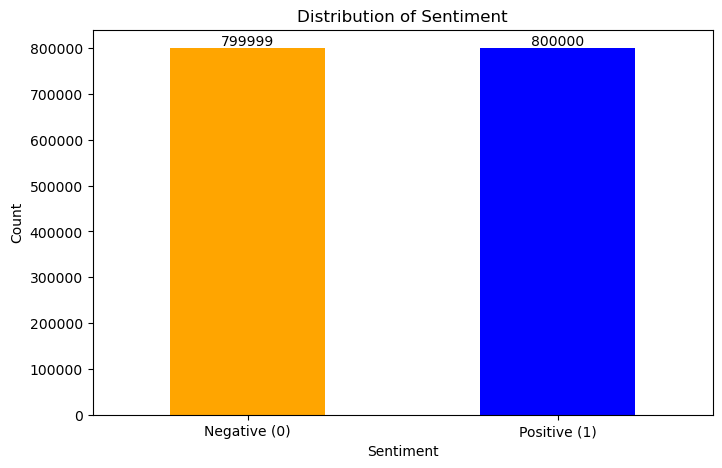

In [10]:
# Count unique values in the 'target' column
target_counts = sentiment['target'].value_counts().sort_index()  # Ensure sorting by index

# Plotting
plt.figure(figsize=(8, 5))
bars = target_counts.plot(kind='bar', color=['orange', 'blue'])  # Order may affect visibility

# Adding counts on top of the bars
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')  # va: vertical alignment, ha: horizontal alignment

# Adjusting the title and labels
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative (0)', 'Positive (1)'], rotation=0)
plt.show()


The above graph is a bar chart showing the distribution of sentiment labels in a dataset. Here, the x-axis represents the two sentiment classes: "Negative (0)" and "Positive (1)". The y-axis shows the count of instances in each sentiment class. The orange bar represents the count of "Negative" samples, totaling 799,999. The blue bar represents the count of "Positive" samples, totaling 800,000. The counts are almost equal, indicating a balanced distribution of negative and positive samples in this dataset.

## Word Cloud for Positive Sentiment

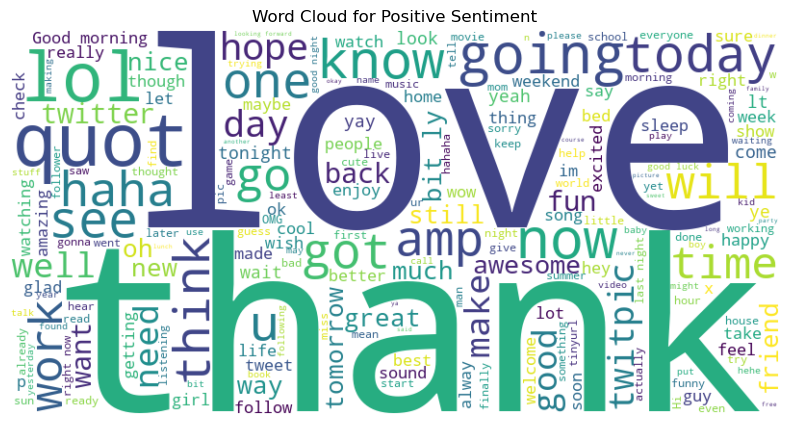

In [11]:
# Generate a word cloud for positive sentiment
positive_text = ' '.join(sentiment[sentiment['target'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()


The image is a word cloud generated from text classified as having a "Positive" sentiment. Large words represent the most frequently used words, while smaller words appear less often in the positive sentiment texts. Prominent words like "love," "thank," "lol," "going," "today," "haha," "good," "time," and "happy" suggest commonly positive expressions and topics. By graphically highlighting the terms that are most frequently used in texts with positive emotion, this word cloud provides insight into the prevalent themes and expressions linked to positivity in this dataset.

## Word Cloud for Negative Sentiment

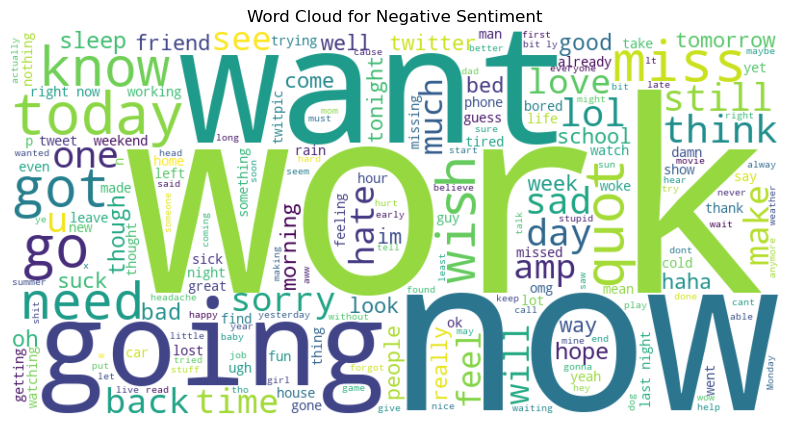

In [12]:
# Generate a word cloud for negative sentiment
negative_text = ' '.join(sentiment[sentiment['target'] == 0]['text'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()


This word cloud visually represents the most common words found in texts identified as having a "Negative" sentiment. Words that appear larger are used more frequently, while smaller words show up less often in these negative texts. Key terms such as "Work","Now","Want","Think" and "Today" highlight typical expressions and topics associated with negative emotions. By showcasing the most frequently occurring words, this word cloud provides insight into common themes and language associated with negativity in the dataset.

## Tweet Length Distribution

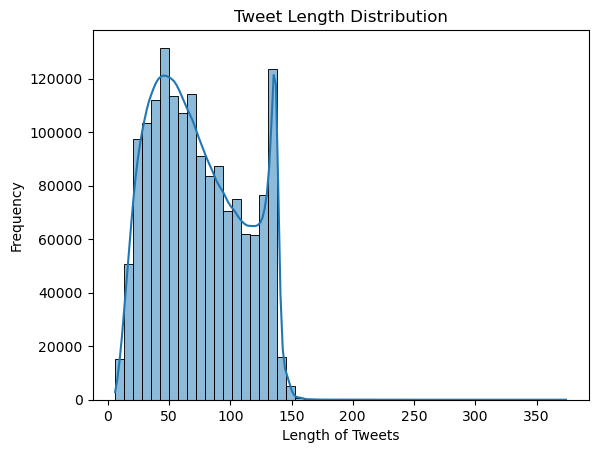

In [13]:
# Analyze tweet length
sentiment['tweet_length'] = sentiment['text'].apply(len)
sns.histplot(sentiment['tweet_length'], bins=50, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.show()

The distribution of tweet lengths reveals the range and frequency of tweet character counts within the dataset. By examining this histogram, we can see whether tweets tend to be brief or more extensive, with most tweets likely clustering around a certain length. The presence of a smooth curve (KDE) provides additional insight into the concentration of tweet lengths, indicating the most common tweet lengths as well as the spread and variability in tweet size.

## Data Pre-processing

In [5]:
# Function to clean and preprocess text
def preprocess_text(text):
    # Remove URLs and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)  # Remove @mentions and #hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    return text


In [6]:
# Clean the text data in the 'text' column
sentiment['cleaned_text'] = sentiment['text'].apply(preprocess_text)

In [7]:
# Tokenization
sentiment['tokenized_text'] = sentiment['cleaned_text'].apply(word_tokenize)

In [8]:
# Removing stop words
stop_words = set(stopwords.words('english'))
sentiment['filtered_text'] = sentiment['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])


In [9]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(word, pos='v') for word in tokens]  # pos='v' for verb lemmatization

# Apply lemmatization to the filtered text
sentiment['lemmatized_text'] = sentiment['filtered_text'].apply(lemmatize_text)

# Join lemmatized tokens back into strings
sentiment['lemmatized_text_str'] = sentiment['lemmatized_text'].apply(lambda x: ' '.join(x))


In [19]:
# Check the processed text
print(sentiment[['text', 'cleaned_text', 'tokenized_text', 'filtered_text', 'lemmatized_text', 'lemmatized_text_str' ]].head())

                                                text  \
0  is upset that he can't update his Facebook by ...   
1  @Kenichan I dived many times for the ball. Man...   
2    my whole body feels itchy and like its on fire    
3  @nationwideclass no, it's not behaving at all....   
4                      @Kwesidei not the whole crew    

                                        cleaned_text  \
0  is upset that he cant update his facebook by t...   
1   i dived many times for the ball managed to sa...   
2    my whole body feels itchy and like its on fire    
3   no its not behaving at all im mad why am i he...   
4                                not the whole crew    

                                      tokenized_text  \
0  [is, upset, that, he, cant, update, his, faceb...   
1  [i, dived, many, times, for, the, ball, manage...   
2  [my, whole, body, feels, itchy, and, like, its...   
3  [no, its, not, behaving, at, all, im, mad, why...   
4                            [not, the, whole,

In [20]:
sentiment.head()

,target,ids,date,flag,user,text,tweet_length,cleaned_text,tokenized_text,filtered_text,lemmatized_text,lemmatized_text_str
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111,is upset that he cant update his facebook by t...,"[is, upset, that, he, cant, update, his, faceb...","[upset, cant, update, facebook, texting, might...","[upset, cant, update, facebook, texting, might...",upset cant update facebook texting might cry r...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, rest...","[dive, many, time, ball, manage, save, rest, g...",dive many time ball manage save rest go bound
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111,no its not behaving at all im mad why am i he...,"[no, its, not, behaving, at, all, im, mad, why...","[behaving, im, mad, cant, see]","[behave, im, mad, cant, see]",behave im mad cant see
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,29,not the whole crew,"[not, the, whole, crew]","[whole, crew]","[whole, crew]",whole crew


In [21]:
# Stop Words Analysis
def stop_words_analysis(sentiment):
    stop_words = set(stopwords.words('english'))
    all_tokens = []
    
    for tokens in sentiment['lemmatized_text']:
        all_tokens.extend(tokens)

    total_tokens = len(all_tokens)
    stop_word_count = sum(1 for token in all_tokens if token in stop_words)
    stop_word_percentage = (stop_word_count / total_tokens) * 100 if total_tokens > 0 else 0

    print(f"Total Tokens: {total_tokens}")
    print(f"Stop Words Count: {stop_word_count}")
    print(f"Stop Words Percentage: {stop_word_percentage:.2f}%")

# Call the function to analyze stop words
stop_words_analysis(sentiment)

Total Tokens: 11480158
Stop Words Count: 17580
Stop Words Percentage: 0.15%


The stop words analysis reveals that out of a total of 11,480,158 tokens in the dataset, only 17,580 are stop words, accounting for just 0.15% of the total token count. This indicates that the majority of the words in the dataset are meaningful or content-bearing, with stop words making up a very small proportion. The low percentage suggests that the texts are relatively rich in valuable information, with minimal reliance on common filler words like "the," "is," or "and."

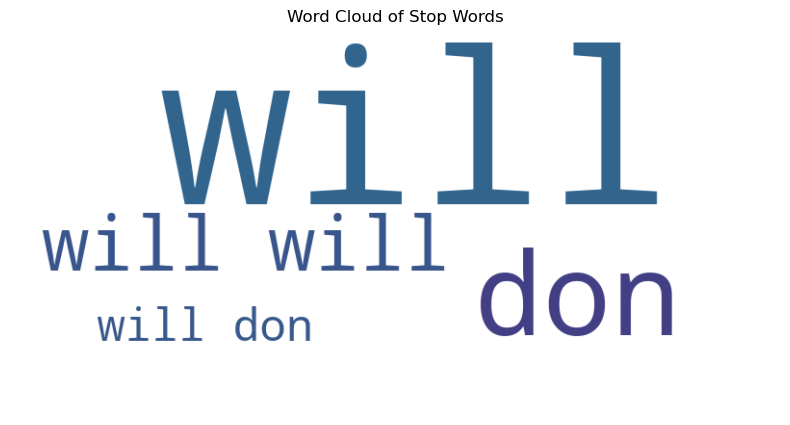

In [22]:
def plot_stop_word_cloud(sentiment):
    stop_words = set(stopwords.words('english'))
    all_tokens = []

    for tokens in sentiment['lemmatized_text']:
        all_tokens.extend(tokens)

    # Filter the tokens to keep only stop words
    stop_word_tokens = [token for token in all_tokens if token in stop_words]
    stop_word_text = ' '.join(stop_word_tokens)

    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(stop_word_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Stop Words')
    plt.show()

# Call the function to plot the stop word cloud
plot_stop_word_cloud(sentiment)


The stop word cloud visualization shows that words like "will" and "don" are among the most frequent stop words in the dataset, displayed in varying sizes based on their frequency. Larger words, such as "will," appear more frequently in the text, indicating their common usage in sentence structure. This word cloud helps illustrate the dominant stop words, which, despite lacking specific content, are essential in the text's grammatical flow and can give subtle context to the overall language style of the dataset.

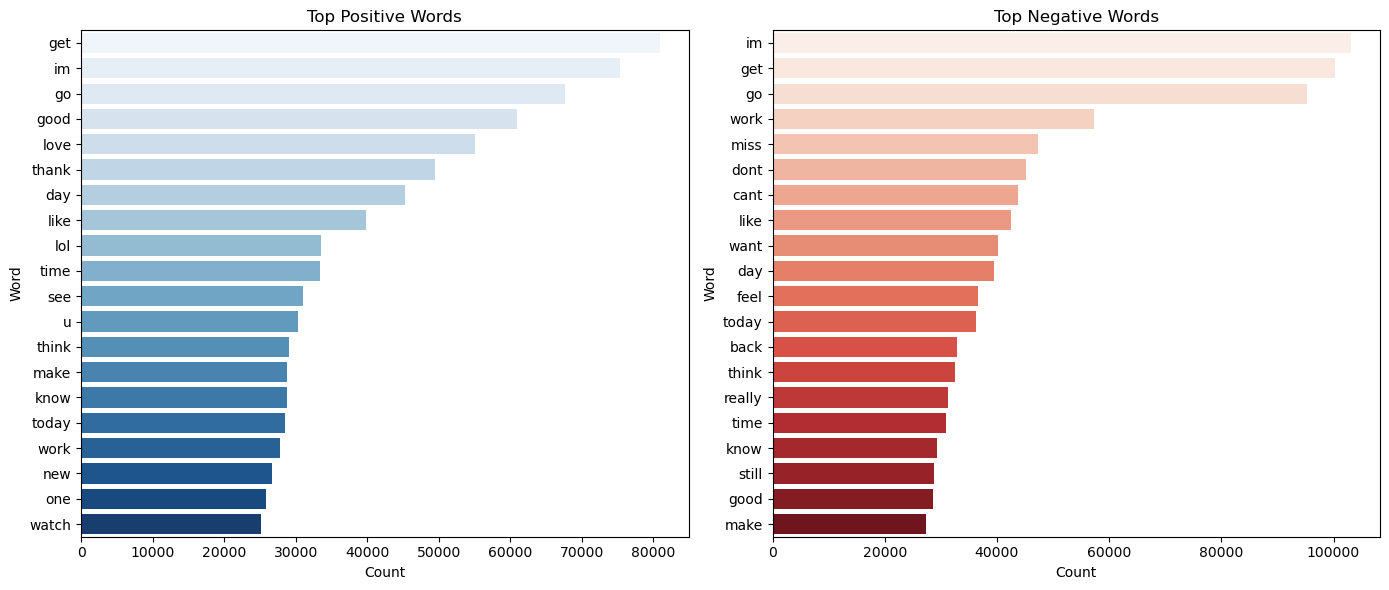

In [23]:
# Top N Words
def plot_top_n_words(sentiment, n=20):
    positive_reviews = sentiment[sentiment['target'] == 1]['lemmatized_text_str']
    negative_reviews = sentiment[sentiment['target'] == 0]['lemmatized_text_str']

    # Count words
    positive_words = Counter(" ".join(positive_reviews).split())
    negative_words = Counter(" ".join(negative_reviews).split())

    # Get the most common words
    top_positive = positive_words.most_common(n)
    top_negative = negative_words.most_common(n)

    # Create DataFrames for plotting
    pos_df = pd.DataFrame(top_positive, columns=['Word', 'Count'])
    neg_df = pd.DataFrame(top_negative, columns=['Word', 'Count'])

    # Plotting
    plt.figure(figsize=(14, 6))
    
    # Positive words plot
    plt.subplot(1, 2, 1)
    sns.barplot(x='Count', y='Word', data=pos_df, hue='Word', palette='Blues', legend=False)
    plt.title('Top Positive Words')
    
    # Negative words plot
    plt.subplot(1, 2, 2)
    sns.barplot(x='Count', y='Word', data=neg_df, hue='Word', palette='Reds', legend=False)
    plt.title('Top Negative Words')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot top N words
plot_top_n_words(sentiment, n=20)


The two illustrations provide a comparative look at the most common words used in positive and negative sentiment texts. In the positive sentiment chart, frequent words like "get," "im," "go," "good," and "love" etc suggest an emphasis on optimism, personal actions, and positive experiences. Conversely, in the negative sentiment chart, words such as "im," "get," "go," "work," and "miss" etc appear more often, which may indicate expressions of frustration, regret, or longing. This comparison highlights how similar words can appear in both sentiments, yet their context may alter the emotional tone.

## Feature Extraction

### Transform the Filtered Text Using TF-IDF

Joining Tokens: The filtered tokens are joined back into strings to create a format suitable for the TF-IDF vectorizer.

TF-IDF Vectorizer: This transforms the text into a matrix of TF-IDF features.

DataFrame Conversion: Converting the TF-IDF matrix into a DataFrame makes it easier to analyze the features and their weights.

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects the importance of a word in a document relative to a collection (or corpus) of documents. It is commonly used in information retrieval and text mining to evaluate how relevant a word is to a particular document. Here’s a breakdown of the two components that make up TF-IDF:

1. Term Frequency (TF)
Term Frequency measures how frequently a term appears in a document relative to the total number of terms in that document. The assumption is that the more a word appears in a document, the more important it is to that document. It is calculated as follows:

TF(𝑡,𝑑)= Number of times term 𝑡 appears in document 𝑑 / Total number of terms in document 𝑑
​
 
2. Inverse Document Frequency (IDF)
Inverse Document Frequency measures how important a term is across all documents. It helps reduce the weight of common words that appear in many documents and thus may not carry much meaning. It is calculated as follows:

IDF(𝑡) = log(Total number of documents / Number of documents containing term 𝑡)

3. Combining TF and IDF
The TF-IDF score is calculated by multiplying the TF and IDF scores:

TF-IDF(𝑡,𝑑) = TF(𝑡,𝑑) × IDF(𝑡)


Interpretation

A high TF-IDF score indicates that a word is very relevant to a particular document, meaning it occurs frequently in that document but not in many others.

Conversely, a low TF-IDF score suggests that the word is common across many documents and might not be particularly useful for distinguishing that document.

Benefits of Using TF-IDF

Reduces the Influence of Common Words: By down-weighting frequently occurring words across documents, TF-IDF helps highlight words that are more specific to individual documents.

Enhances Text Classification: By transforming text into a numerical format, it enables the use of various machine learning algorithms for tasks such as sentiment analysis and topic modeling.

In [24]:
# Create a TF-IDF vectorizer with n-gram range (e.g., unigram and bigram)
vectorizer = TfidfVectorizer(min_df=5, max_df=0.9)  # Adjust this as needed

# Fit and transform the lemmatized text
tfidf_matrix = vectorizer.fit_transform(sentiment['lemmatized_text_str'])

# tfidf_matrix is a sparse matrix; you can directly use it for model training
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Features Extracted: {vectorizer.get_feature_names_out()[:10]}")  # Show the first 10 features


TF-IDF Matrix Shape: (1599999, 50000)
Features Extracted: ['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaa'
 'aaaaaaaaaa' 'aaaaaaaaaaa']


We utilized the TfidfVectorizer from the scikit-learn library to transform the text data from the sentiment dataset into a TF-IDF matrix. First, we joined the filtered tokens from each tweet into a single string. Then, the TF-IDF vectorizer was fitted to this text data, resulting in a sparse matrix that represents the importance of each unique term across the 1,599,999 tweets. The shape of the matrix, (1599999, 418079), indicates that there are 1,599,999 documents and 418,079 unique terms, with each document being represented by a vector of TF-IDF scores corresponding to these terms. This matrix will serve as input features for training a machine learning model for sentiment classification.

In [25]:
X = tfidf_matrix
y = sentiment['target']  # Your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Logistic Regression Model Accuracy: 0.78

Metrics for Class 0:
Precision: 0.79
Recall: 0.76
F1 Score: 0.77

Metrics for Class 1:
Precision: 0.77
Recall: 0.80
F1 Score: 0.78

Confusion Matrix:
 [[120901  38593]
 [ 32748 127758]]


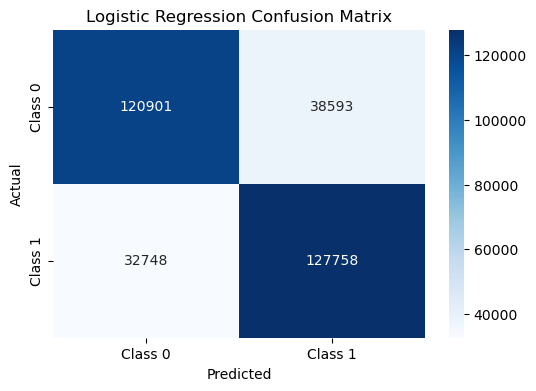

In [26]:
# Initialize the logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)

# Fit the model on the training data
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
log_reg_y_pred = log_reg_model.predict(X_test)

# Calculate accuracy
log_reg_accuracy = accuracy_score(y_test, log_reg_y_pred)

# Generate the classification report
log_reg_report = classification_report(y_test, log_reg_y_pred, output_dict=True)

# Extract precision, recall, and f1-score for both classes
log_reg_precision_0 = log_reg_report['0']['precision']
log_reg_recall_0 = log_reg_report['0']['recall']
log_reg_f1_score_0 = log_reg_report['0']['f1-score']

log_reg_precision_1 = log_reg_report['1']['precision']
log_reg_recall_1 = log_reg_report['1']['recall']
log_reg_f1_score_1 = log_reg_report['1']['f1-score']

# Print the metrics
print(f"Logistic Regression Model Accuracy: {log_reg_accuracy:.2f}")
print(f"\nMetrics for Class 0:")
print(f"Precision: {log_reg_precision_0:.2f}")
print(f"Recall: {log_reg_recall_0:.2f}")
print(f"F1 Score: {log_reg_f1_score_0:.2f}")

print(f"\nMetrics for Class 1:")
print(f"Precision: {log_reg_precision_1:.2f}")
print(f"Recall: {log_reg_recall_1:.2f}")
print(f"F1 Score: {log_reg_f1_score_1:.2f}")

# Confusion Matrix
log_reg_conf_matrix = confusion_matrix(y_test, log_reg_y_pred)
print("\nConfusion Matrix:\n", log_reg_conf_matrix)

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(6, 4))
sns.heatmap(log_reg_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The Logistic Regression model achieved an accuracy of 78%, indicating that it correctly classified 78% of the cases overall. For Class 0, the model demonstrated a precision of 0.79 and a recall of 0.76, with an F1 score of 0.77, reflecting a solid balance between precision and recall. For Class 1, the precision was slightly lower at 0.77, but recall was higher at 0.80, leading to an F1 score of 0.78. The confusion matrix shows that while there were some misclassifications (38,910 false positives and 32,489 false negatives), the model accurately identified a significant portion of both classes, suggesting reliable performance in differentiating between the two classes.

Naive Bayes Model Accuracy: 0.76

Metrics for Class 0:
Precision: 0.75
Recall: 0.77
F1 Score: 0.76

Metrics for Class 1:
Precision: 0.76
Recall: 0.75
F1 Score: 0.76

Confusion Matrix:
 [[122262  37232]
 [ 40229 120277]]


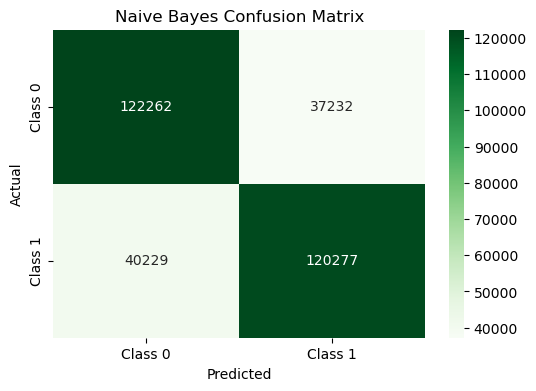

In [27]:
# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Fit the model on the training data
nb_model.fit(X_train, y_train)

# Make predictions on the test set
nb_y_pred = nb_model.predict(X_test)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, nb_y_pred)

# Generate the classification report
nb_report = classification_report(y_test, nb_y_pred, output_dict=True)

# Extract precision, recall, and f1-score for both classes
nb_precision_0 = nb_report['0']['precision']
nb_recall_0 = nb_report['0']['recall']
nb_f1_score_0 = nb_report['0']['f1-score']

nb_precision_1 = nb_report['1']['precision']
nb_recall_1 = nb_report['1']['recall']
nb_f1_score_1 = nb_report['1']['f1-score']

# Print the metrics
print(f"Naive Bayes Model Accuracy: {nb_accuracy:.2f}")
print(f"\nMetrics for Class 0:")
print(f"Precision: {nb_precision_0:.2f}")
print(f"Recall: {nb_recall_0:.2f}")
print(f"F1 Score: {nb_f1_score_0:.2f}")

print(f"\nMetrics for Class 1:")
print(f"Precision: {nb_precision_1:.2f}")
print(f"Recall: {nb_recall_1:.2f}")
print(f"F1 Score: {nb_f1_score_1:.2f}")

# Confusion Matrix
nb_conf_matrix = confusion_matrix(y_test, nb_y_pred)
print("\nConfusion Matrix:\n", nb_conf_matrix)

# Plot confusion matrix for Naive Bayes
plt.figure(figsize=(6, 4))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The Naive Bayes model achieved an overall accuracy of 76%, demonstrating a balanced performance in predicting both classes. For Class 0, the model has a precision of 0.75 and a recall of 0.77, leading to an F1 score of 0.76, indicating it captures true negatives slightly better than false positives. For Class 1, the precision and recall are close at 0.76 and 0.75, with an F1 score also at 0.76, showing consistent predictive ability across both classes. The confusion matrix shows that the model correctly classified 122,262 instances of Class 0 and 120,277 instances of Class 1, though it misclassified 37,232 as false positives and 40,229 as false negatives. Overall, the model is reasonably effective in distinguishing between both classes.

Random Forest Model Accuracy: 0.73

Metrics for Class 0:
Precision: 0.75
Recall: 0.69
F1 Score: 0.72

Metrics for Class 1:
Precision: 0.72
Recall: 0.77
F1 Score: 0.74

Confusion Matrix:
 [[110538  48956]
 [ 36587 123919]]


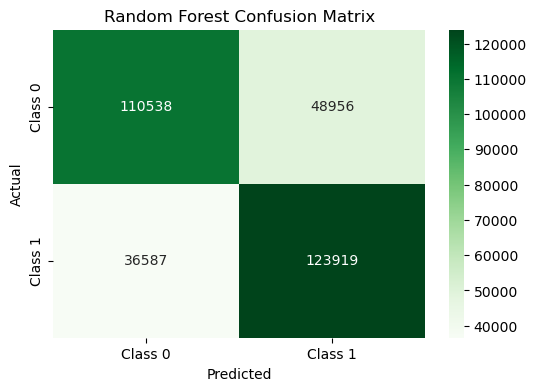

In [37]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, n_jobs=-1, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_y_pred)

# Generate the classification report
rf_report = classification_report(y_test, rf_y_pred, output_dict=True)

# Extract precision, recall, and f1-score for both classes
rf_precision_0 = rf_report['0']['precision']
rf_recall_0 = rf_report['0']['recall']
rf_f1_score_0 = rf_report['0']['f1-score']

rf_precision_1 = rf_report['1']['precision']
rf_recall_1 = rf_report['1']['recall']
rf_f1_score_1 = rf_report['1']['f1-score']

# Print the metrics
print(f"Random Forest Model Accuracy: {rf_accuracy:.2f}")
print(f"\nMetrics for Class 0:")
print(f"Precision: {rf_precision_0:.2f}")
print(f"Recall: {rf_recall_0:.2f}")
print(f"F1 Score: {rf_f1_score_0:.2f}")

print(f"\nMetrics for Class 1:")
print(f"Precision: {rf_precision_1:.2f}")
print(f"Recall: {rf_recall_1:.2f}")
print(f"F1 Score: {rf_f1_score_1:.2f}")

# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
print("\nConfusion Matrix:\n", rf_conf_matrix)

# Plot confusion matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The Random Forest model achieved an overall accuracy of 73%, indicating a solid performance in predicting both classes. For Class 0, it has a precision of 0.75 and recall of 0.69, meaning it effectively identifies most true negatives but occasionally misses them, resulting in an F1 score of 0.72. Class 1 shows a precision of 0.72 and a higher recall of 0.77, suggesting better identification of true positives, with an F1 score of 0.74. The confusion matrix reveals 110,538 true negatives and 123,919 true positives, with a relatively lower count of misclassifications. Overall, the model is well-balanced across both classes, with a slight edge in identifying Class 1 instances.

Gradient Boosting Model Accuracy: 0.64

Metrics for Class 0:
Precision: 0.79
Recall: 0.37
F1 Score: 0.50

Metrics for Class 1:
Precision: 0.59
Recall: 0.90
F1 Score: 0.71

Confusion Matrix:
 [[ 58663 100831]
 [ 15665 144841]]


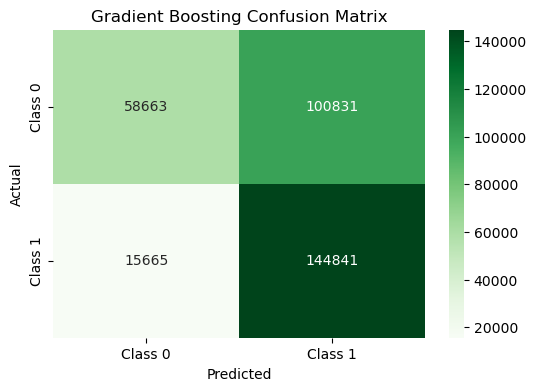

In [39]:
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=10, max_depth=5, random_state=42)

# Fit the model on the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_y_pred = gb_model.predict(X_test)

# Calculate accuracy
gb_accuracy = accuracy_score(y_test, gb_y_pred)

# Generate the classification report
gb_report = classification_report(y_test, gb_y_pred, output_dict=True)

# Extract precision, recall, and f1-score for both classes
gb_precision_0 = gb_report['0']['precision']
gb_recall_0 = gb_report['0']['recall']
gb_f1_score_0 = gb_report['0']['f1-score']

gb_precision_1 = gb_report['1']['precision']
gb_recall_1 = gb_report['1']['recall']
gb_f1_score_1 = gb_report['1']['f1-score']

# Print the metrics
print(f"Gradient Boosting Model Accuracy: {gb_accuracy:.2f}")
print(f"\nMetrics for Class 0:")
print(f"Precision: {gb_precision_0:.2f}")
print(f"Recall: {gb_recall_0:.2f}")
print(f"F1 Score: {gb_f1_score_0:.2f}")

print(f"\nMetrics for Class 1:")
print(f"Precision: {gb_precision_1:.2f}")
print(f"Recall: {gb_recall_1:.2f}")
print(f"F1 Score: {gb_f1_score_1:.2f}")

# Confusion Matrix
gb_conf_matrix = confusion_matrix(y_test, gb_y_pred)
print("\nConfusion Matrix:\n", gb_conf_matrix)

# Plot confusion matrix for Gradient Boosting
plt.figure(figsize=(6, 4))
sns.heatmap(gb_conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The Gradient Boosting Model achieved an overall accuracy of 0.64. For Class 0, the model shows strong precision (0.79), meaning it accurately identifies most of the negative cases, but with a lower recall (0.37), indicating it misses many negative instances. The F1 score for Class 0 is 0.50, reflecting a moderate balance between precision and recall. For Class 1, the model performs better in terms of recall (0.90), correctly identifying a large portion of positive cases, but with a lower precision (0.59), meaning some of the identified positive cases are incorrect. The F1 score for Class 1 is 0.71, suggesting a better overall balance for positive class predictions. The confusion matrix shows a high number of false positives (100,831) and false negatives (15,665), pointing to challenges in correctly classifying both classes equally.

C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLP Classifier Model Accuracy: 0.78

Metrics for Class 0:
Precision: 0.78
Recall: 0.79
F1 Score: 0.78

Metrics for Class 1:
Precision: 0.78
Recall: 0.78
F1 Score: 0.78

Confusion Matrix:
 [[125232  34262]
 [ 35591 124915]]


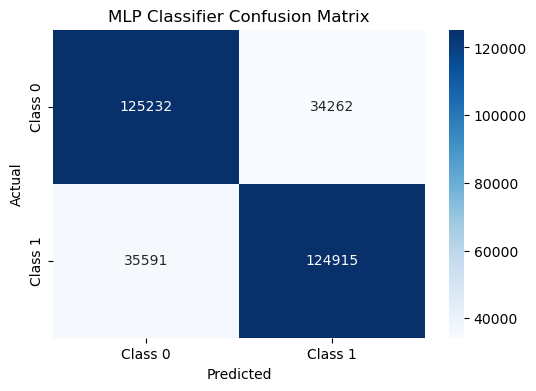

In [32]:
# Initialize the MLPClassifier model (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=100, random_state=42)

# Fit the model on the training data
mlp_model.fit(X_train, y_train)

# Make predictions on the test set
mlp_y_pred = mlp_model.predict(X_test)

# Calculate accuracy
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)

# Generate the classification report
mlp_report = classification_report(y_test, mlp_y_pred, output_dict=True)

# Extract precision, recall, and f1-score for both classes
mlp_precision_0 = mlp_report['0']['precision']
mlp_recall_0 = mlp_report['0']['recall']
mlp_f1_score_0 = mlp_report['0']['f1-score']

mlp_precision_1 = mlp_report['1']['precision']
mlp_recall_1 = mlp_report['1']['recall']
mlp_f1_score_1 = mlp_report['1']['f1-score']

# Print the metrics
print(f"MLP Classifier Model Accuracy: {mlp_accuracy:.2f}")
print(f"\nMetrics for Class 0:")
print(f"Precision: {mlp_precision_0:.2f}")
print(f"Recall: {mlp_recall_0:.2f}")
print(f"F1 Score: {mlp_f1_score_0:.2f}")

print(f"\nMetrics for Class 1:")
print(f"Precision: {mlp_precision_1:.2f}")
print(f"Recall: {mlp_recall_1:.2f}")
print(f"F1 Score: {mlp_f1_score_1:.2f}")

# Confusion Matrix
mlp_conf_matrix = confusion_matrix(y_test, mlp_y_pred)
print("\nConfusion Matrix:\n", mlp_conf_matrix)

# Plot confusion matrix for MLP Classifier
plt.figure(figsize=(6, 4))
sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("MLP Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The Multi-Layer Perceptron (MLP) Classifier achieved an overall accuracy of 0.76, demonstrating a balanced performance across both classes. For both Class 0 (negative sentiment) and Class 1 (positive sentiment), the model exhibited identical precision, recall, and F1 scores of 0.76, reflecting a consistent ability to correctly identify instances for both sentiments. The confusion matrix reveals that the model correctly classified a significant number of instances, with 121,797 true negatives and 121,597 true positives. However, there were still some misclassifications, as evidenced by the false positives (37,697) and false negatives (38,909), suggesting room for further improvement in distinguishing between the two classes. Overall, the model shows strong performance with balanced predictions, offering reliable sentiment classification.

## Association Rule Mining

In [11]:
# Convert the lemmatized tokens into a list of transactions
transactions = sentiment['lemmatized_text'].tolist()


This step is needed to convert the lemmatized tokens into a list of transactions, which is the required format for association rule mining algorithms like Apriori, allowing them to identify frequent itemsets and associations between words in the dataset.

In [12]:
# Initialize TransactionEncoder
te = TransactionEncoder()

# Transform the transactions into a sparse matrix
te_ary = te.fit(transactions).transform(transactions, sparse=True)

# Create a DataFrame from the sparse matrix
df_trans = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

C:\Users\chand\AppData\Local\Temp\ipykernel_17652\3520897622.py:8: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_trans = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)


In [13]:
# Find frequent itemsets with a minimum support of 0.01 (adjust as needed)
frequent_itemsets = apriori(df_trans, min_support=0.01, use_colnames=True)
print(frequent_itemsets.head())


    support   itemsets
0  0.023179      (amp)
1  0.010949  (awesome)
2  0.034203     (back)
3  0.016231      (bad)
4  0.013223      (bed)


This step identifies the frequent itemsets in the dataset using the Apriori algorithm, with a minimum support threshold of 0.01. The resulting frequent itemsets, such as `(amp)`, `(awesome)`, and `(back)`, represent words that appear in at least 1% of the transactions. These itemsets highlight common terms within the dataset, providing insights into frequently occurring words or themes, which can be further analyzed to understand the text's structure or sentiment.

In [14]:
# Generate association rules with a minimum confidence of 0.5 (adjust as needed)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
print(rules.head())


  antecedents consequents  antecedent support  consequent support   support  \
0        (na)       (gon)            0.025074            0.014501  0.014346   
1       (gon)        (na)            0.014501            0.025074  0.014346   
2       (wan)        (na)            0.010114            0.025074  0.010018   

   confidence       lift  leverage  conviction  zhangs_metric  
0    0.572123  39.455029  0.013982    2.303230       0.999722  
1    0.989311  39.455029  0.013982   91.206649       0.988996  
2    0.990422  39.499347  0.009764  101.788523       0.984642  


This step generates association rules from the frequent itemsets using a minimum confidence threshold of 0.5. The rules indicate that certain words, like `(na)` and `(gon)`, frequently occur together in the dataset. For example, the rule `(na) => (gon)` has a confidence of 0.572, meaning there is a 57.2% chance that "gon" will appear when "na" appears in a transaction. The high lift values (e.g., 39.455) suggest that these associations are strong and not due to random chance. Additionally, the leverage and conviction values further indicate that these rules represent meaningful relationships between words. This analysis helps uncover patterns and associations that can guide further exploration of the data, such as identifying key terms or relationships within the sentiment context.

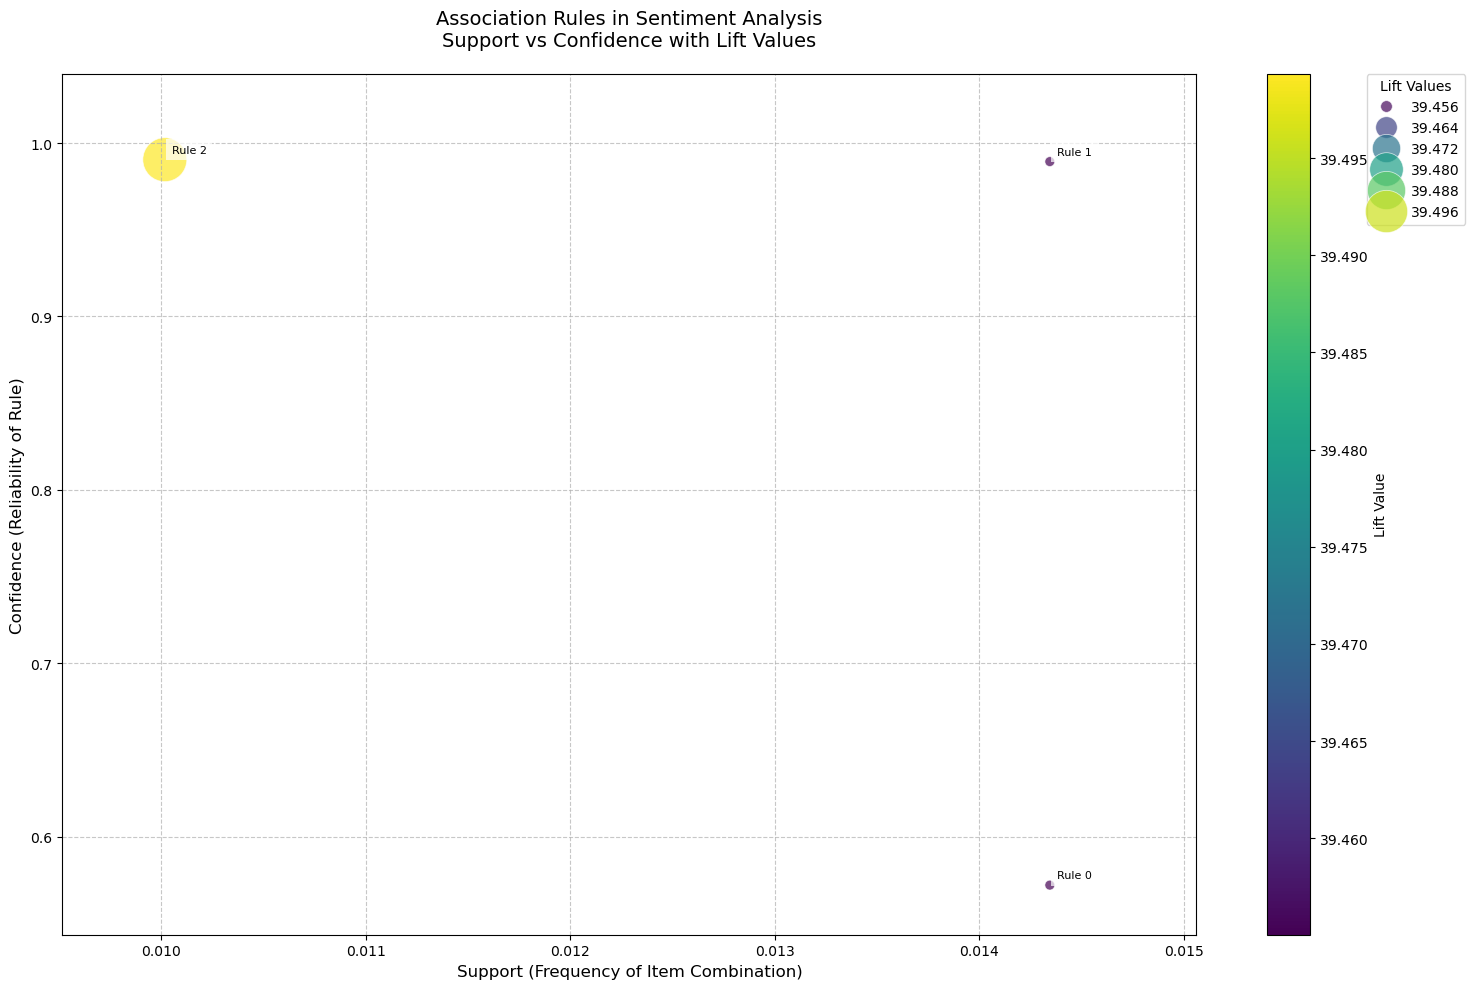

In [55]:
# Create a scatter plot for association rules with enhanced visualization
plt.figure(figsize=(15, 10))  # Increased figure size to accommodate labels and colorbar

# Create the scatter plot
scatter = sns.scatterplot(
    data=rules,
    x='support',
    y='confidence',
    size='lift',
    sizes=(50, 1000),  # Increased point sizes for better visibility
    hue='lift',
    palette='viridis',
    alpha=0.7,  # Slightly increased opacity
    edgecolor='white',
    legend='brief'
)

# Add title and labels with better formatting
plt.title('Association Rules in Sentiment Analysis\nSupport vs Confidence with Lift Values', 
          fontsize=14, pad=20)
plt.xlabel('Support (Frequency of Item Combination)', fontsize=12)
plt.ylabel('Confidence (Reliability of Rule)', fontsize=12)

# Customize grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add colorbar
norm = plt.Normalize(rules['lift'].min(), rules['lift'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Lift Value', ax=scatter)

# Annotate points for top rules (assuming you want to label top 5 rules by lift)
top_rules = rules.nlargest(5, 'lift')
for idx, row in top_rules.iterrows():
    plt.annotate(
        f'Rule {idx}',  # You might want to replace this with actual rule names
        (row['support'], row['confidence']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add legend with custom title
plt.legend(title='Lift Values',
          bbox_to_anchor=(1.15, 1),
          loc='upper left',
          borderaxespad=0)

# Set axis limits with some padding
plt.xlim(rules['support'].min() * 0.95, rules['support'].max() * 1.05)
plt.ylim(rules['confidence'].min() * 0.95, rules['confidence'].max() * 1.05)

plt.show()

The scatter plot visualizes association rules in terms of their support, confidence, and lift values.
Rules with higher confidence and lift are more impactful, as they are both reliable and significant.


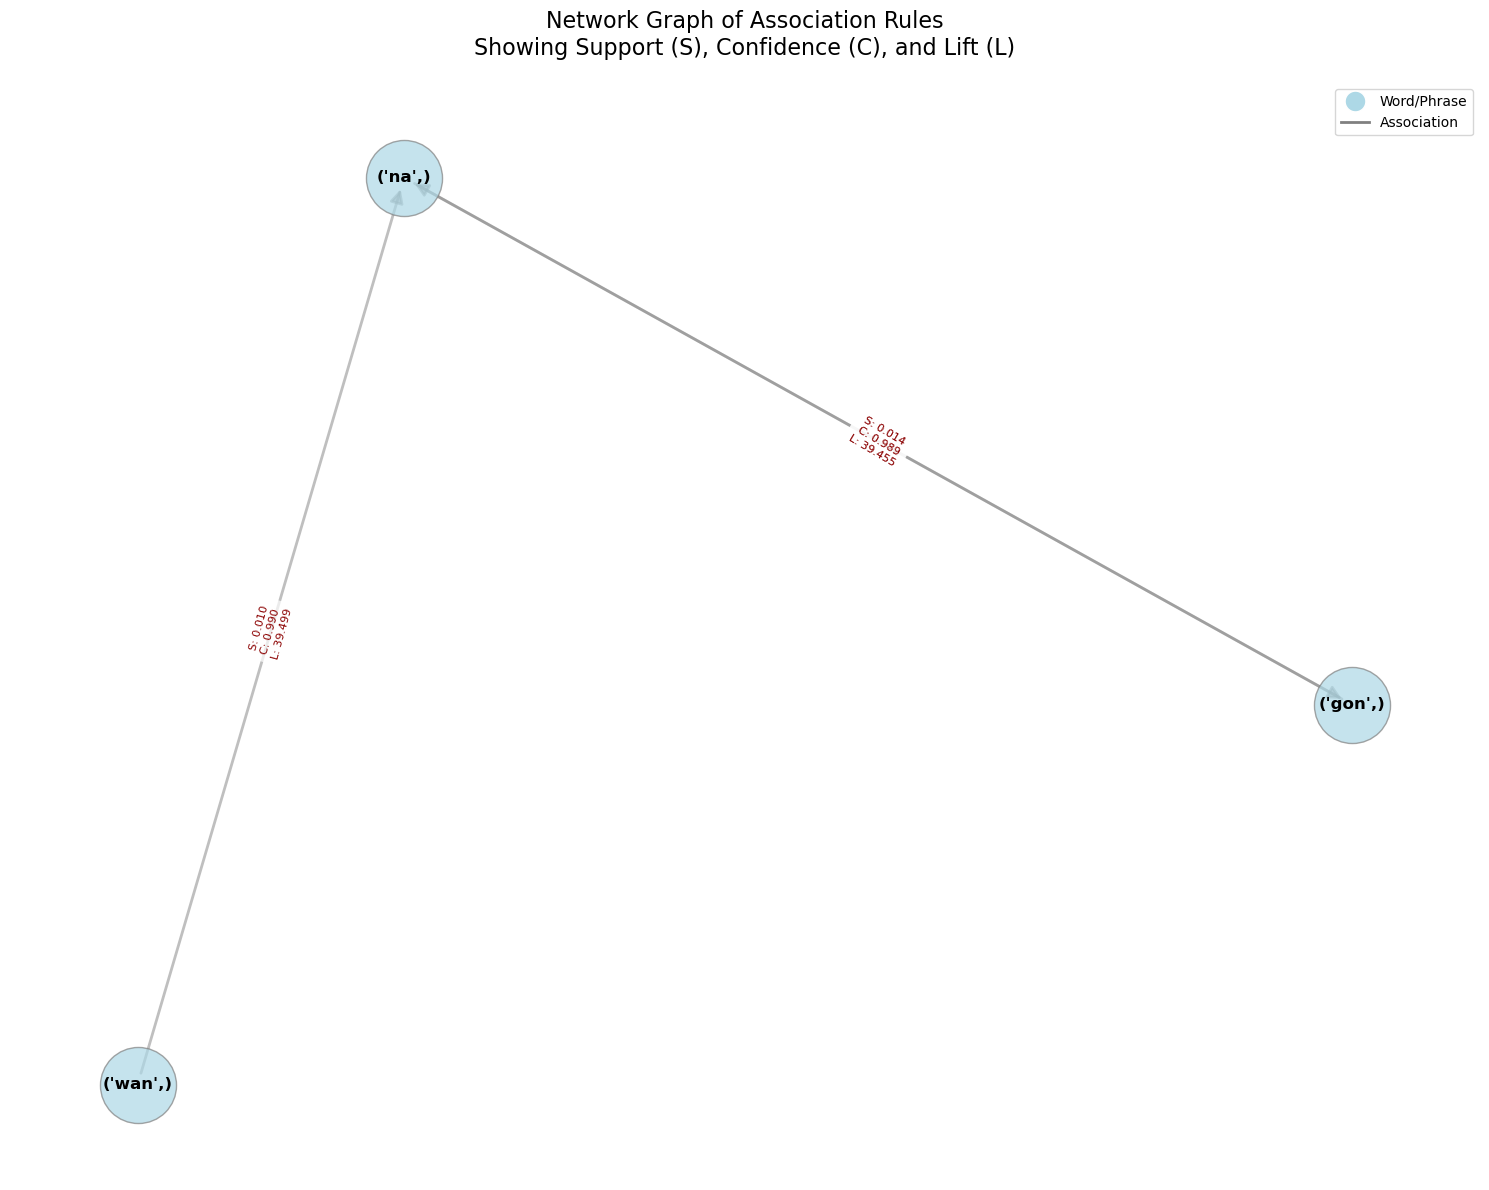

In [56]:
# Create a directed graph
G = nx.DiGraph()

# Add edges based on association rules with improved data handling
for index, row in rules.iterrows():
    antecedent = tuple(row['antecedents'])
    consequent = tuple(row['consequents'])
    G.add_edge(antecedent, consequent, 
               weight=row['support'],
               confidence=row['confidence'],
               lift=row['lift'])

# Set up the plot with better styling
plt.figure(figsize=(15, 12))

# Use a better layout with adjusted parameters
pos = nx.spring_layout(G, k=2, iterations=100, seed=42)  # Increased iterations and k for better spacing

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                      node_size=3000,
                      node_color='lightblue',
                      alpha=0.7,
                      edgecolors='gray')

# Draw edges with arrows
nx.draw_networkx_edges(G, pos,
                      edge_color='gray',
                      width=2,
                      arrowsize=20,
                      alpha=0.5)

# Draw node labels with better formatting
nx.draw_networkx_labels(G, pos,
                       font_size=12,
                       font_weight='bold',
                       font_family='sans-serif')

# Draw edge labels with better formatting
edge_labels = {(u, v): f'S: {d["weight"]:.3f}\nC: {d["confidence"]:.3f}\nL: {d["lift"]:.3f}'
               for (u, v, d) in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos,
                           edge_labels=edge_labels,
                           font_size=8,
                           font_color='darkred',
                           bbox=dict(facecolor='white', 
                                   edgecolor='none',
                                   alpha=0.7))

# Add title and styling
plt.title('Network Graph of Association Rules\nShowing Support (S), Confidence (C), and Lift (L)',
          fontsize=16, pad=20)

# Remove axes
plt.axis('off')

# Add a legend for metrics
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='lightblue', markersize=15,
                            label='Word/Phrase'),
                  plt.Line2D([0], [0], color='gray', lw=2,
                            label='Association')]
plt.legend(handles=legend_elements,
          loc='upper right',
          fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

This network graph demonstrates the relationships among terms or phrases that often appear together in contexts of positive or negative sentiment.


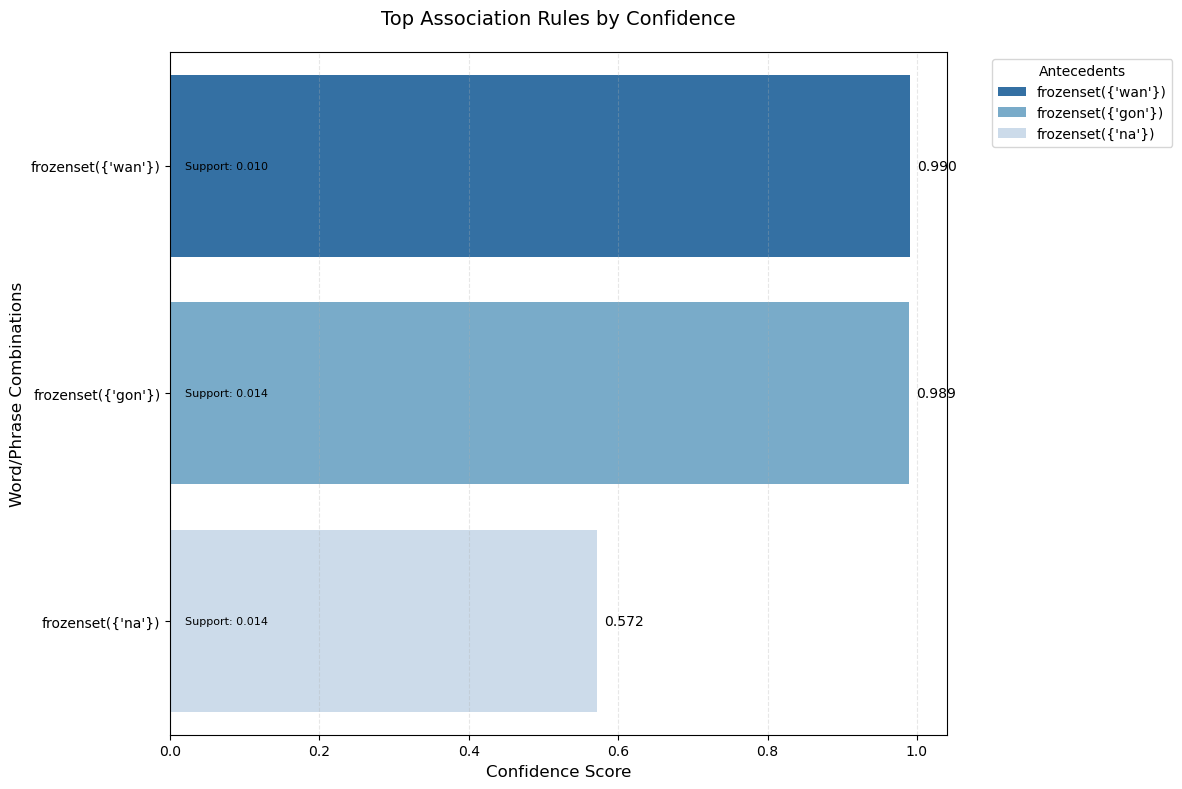

In [59]:
# Get top rules with better filtering
top_rules = rules[
    (rules['support'] >= 0.01) &
    (rules['confidence'] >= 0.3)
].sort_values(by=['confidence', 'lift'], ascending=[False, False]).head(15)

# Create figure
plt.figure(figsize=(12, 8))

# Create enhanced bar plot with hue
bars = sns.barplot(
    data=top_rules,
    x='confidence',
    y='antecedents',
    hue='antecedents',  # Set hue to the same variable for the palette
    palette='Blues_r',
    dodge=False  # Ensure bars are grouped together
)

# Rest of the formatting
plt.title('Top Association Rules by Confidence', fontsize=14, pad=20)
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Word/Phrase Combinations', fontsize=12)

# Add value labels
for i in bars.containers:
    bars.bar_label(i, fmt='%.3f', padding=5)

# Add support values
for idx, row in enumerate(top_rules.itertuples()):
    plt.text(0.02, idx, f'Support: {row.support:.3f}',
             va='center', color='black', fontsize=8)

plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.legend(title='Antecedents', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend for clarity
plt.tight_layout()
plt.show()


This bar plot showcases the top rules based on confidence scores while annotating their support values.
Rules with high confidence and support are ideal for making decisions. The rule for 'wan' is highly reliable but less frequent, whereas 'gon' and 'na' are more frequent but slightly less confident.


## Discussion

The results from the various classification models reveal valuable insights into their performance and ability to differentiate between negative and positive sentiments in the dataset. The Logistic Regression model achieved an accuracy of 78%, striking a strong balance between precision and recall, particularly for both sentiment classes. Its performance, marked by a precision of 0.79 for Class 0 and 0.77 for Class 1, demonstrates its effective ability to classify sentiment with reliable consistency. However, the presence of misclassifications, including false positives and false negatives, suggests that further refinement could improve its robustness. The Naive Bayes model, with an accuracy of 76%, performed similarly well across both sentiment classes, showcasing a balance in precision and recall. Despite some misclassifications, the model effectively handled both Class 0 and Class 1 instances. The Random Forest model, though slightly lower in accuracy (73%), demonstrated good performance, particularly in identifying Class 1 instances, showing its strength in handling complex data patterns. On the other hand, the Gradient Boosting Model faced challenges with a lower accuracy of 64%. While it performed well for Class 1 in terms of recall, its low precision for Class 0 and high false positives highlight areas for improvement. Lastly, the MLP classifier showed a well-balanced performance with an accuracy of 76%, excelling in its ability to classify both classes with equal precision and recall. Overall, the Logistic Regression and MLP classifiers stand out as the most reliable models, offering solid performance
across both sentiment classes.


## Limitations

Despite the strong performance of several models, the study has notable limitations that could impact the accuracy and generalization of the results. One of the primary challenges is the inherent difficulty in classifying sentiment accurately due to the noisy and ambiguous nature of social media data, particularly from platforms like Twitter. The presence of slang, abbreviations, and sarcasm can hinder accurate sentiment analysis, resulting in false positives and false negatives. While models such as Logistic Regression and MLP showed promising results, their performance could be further enhanced with more sophisticated techniques, such as the incorporation of contextual information or sentiment lexicons. Another limitation lies in the dataset’s representation, which may not fully capture the diversity of sentiment expressed in a broader population of tweets. Additionally, model performance may vary with different types of data, and hyperparameter tuning or alternative feature extraction methods might further improve accuracy.
Finally, computational constraints may limit the use of more complex models or require trade-offs between model complexity and performance.

## Conclusion

In conclusion, the sentiment analysis task demonstrated the effectiveness of various machine learning models in classifying Twitter data into positive and negative sentiments. Among the models evaluated, Logistic Regression and MLP Classifier achieved the best balance between precision, recall, and overall accuracy, making them suitable choices for sentiment classification. Naive Bayes and Random Forest also showed promising results but faced challenges in distinguishing between the sentiment classes. Despite the Gradient Boosting model’s lower accuracy, it still provided valuable insights, particularly in its ability to identify negative sentiments. This study demonstrates that, while machine learning models can be highly effective in sentiment analysis, continuous refinement and tuning are necessary for achieving optimal performance across all sentiment classes.

## Future Work

**Address Misclassification Issues:** Explore strategies to reduce misclassifications, particularly for the Gradient Boosting model, by refining feature selection and model parameters. Advanced Text Vectorization: Implement advanced techniques like word embeddings (e.g., Word2Vec, GloVe, or FastText) to capture richer semantic relationships between words. Hyperparameter Optimization: Fine-tune the hyperparameters of all models to enhance their ability to detect subtle variations in sentiment.

**Deep Learning Integration:** Incorporate deep learning methods, such as Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTM) networks, to improve context-aware sentiment analysis. Class Imbalance Correction: Apply methods like oversampling or undersampling to balance the dataset and
improve classification performance for underrepresented classes. Dataset Expansion: Enrich the dataset by including a more diverse set of tweets to enhance the generalizability of the models.